In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

In [2]:
library(tidyverse)
library(caret)
library(ranger)
library(vip)
#library(randomForest)
library(rfUtilities)
library(recipes)
library(pdp)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi



Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial

# Dataset
## Source

    C. Okan Sakar
    Department of Computer Engineering, Faculty of
    Engineering and Natural Sciences, Bahcesehir University,
    34349 Besiktas, Istanbul, Turkey
    Yomi Kastro
    Inveon Information Technologies Consultancy and Trade,
    34335 Istanbul, Turkey

## Data Set Information:

The dataset consists of feature vectors belonging to 12,330 sessions.
The dataset was formed so that each session
would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user
profile, or period.

## Attribute Information:

The dataset consists of 10 numerical and 8 categorical attributes.
* The 'Revenue' attribute can be used as the class label.
* "Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.
* The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. 
  * The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.
  * The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.
  * The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
* The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 
* The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

[source](https://www.kaggle.com/roshansharma/online-shoppers-intention)

In [3]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_character()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

In [4]:
categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

In [5]:
set.seed(42)
index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
retention_train <- data[index_train, ]
retention_test  <- data[-index_train, ]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [6]:
retention_recipe <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_mutate(Revenue = factor(Revenue, labels=c("Yes", "No"), levels = c(TRUE, FALSE)))
    
prep_retention  <-  prep(retention_recipe)
retention_train_clean  <-  bake(prep_retention, retention_train)
retention_test_clean  <-  bake(prep_retention, retention_test)

In [7]:
head(retention_train_clean)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,No
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,No
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,No
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,No
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,No
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,No


# Modeling

## Random Forest

In [8]:
set.seed(42)
retention_model <- ranger(
    Revenue ~ .,
    data = retention_train_clean,
    importance = "impurity",
    classification = TRUE,
    probability = TRUE,
    #num.trees = 50,
    min.node.size = 10,
    mtry = 8
)

## Feature importance

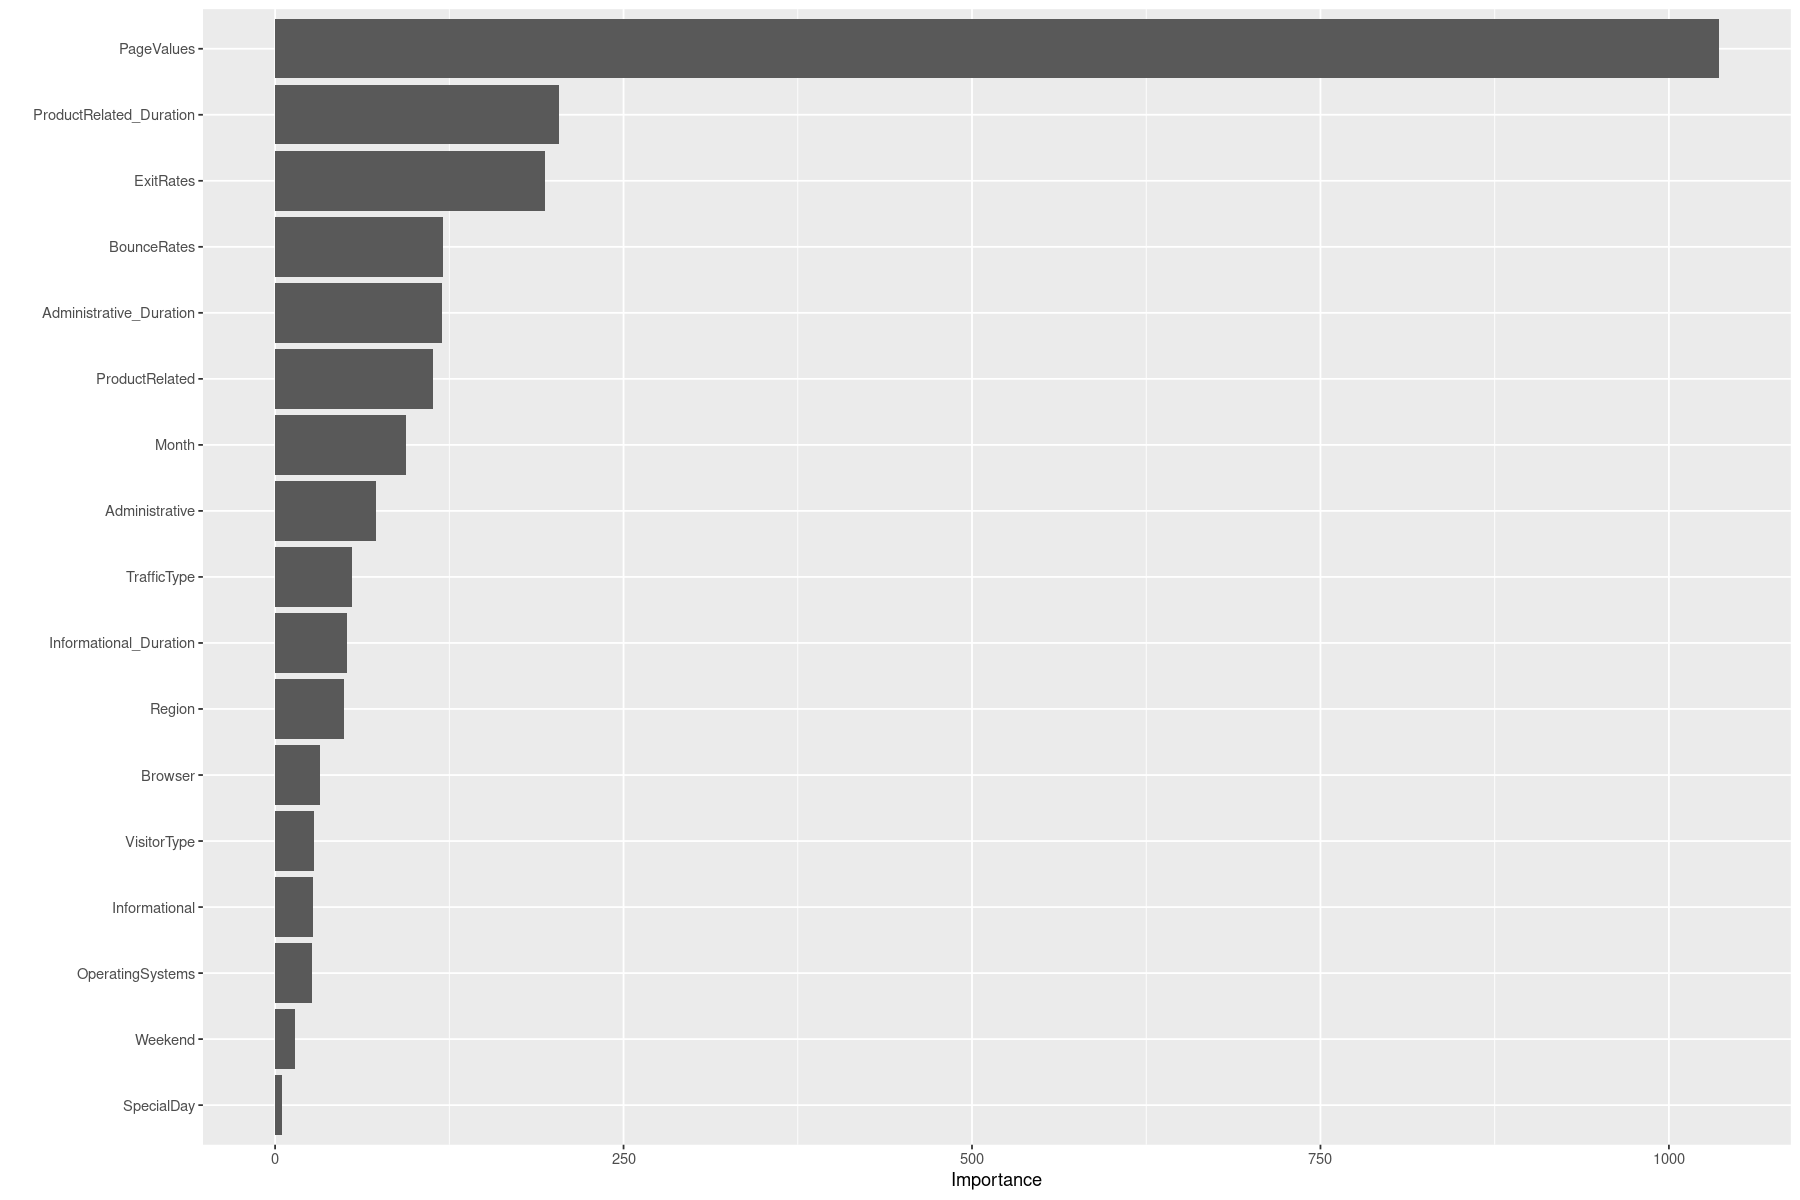

In [9]:
p1 <- vip::vip(retention_model, num_features = 25, )
p1

## Calibracion de probabilidad

In [10]:
data_to_eval = retention_train_clean

result_rF  <- data.frame(obs = data_to_eval$Revenue,
                         pred_prob = predict(retention_model, data = data_to_eval)$predictions[, 1]
                        )
head(result_rF)

,obs,pred_prob
,<fct>,<dbl>
1,No,0.0000000000
2,No,0.0000000000
3,No,0.0000000000
4,No,0.0005714286
5,No,0.0020000000
6,No,0.0000000000


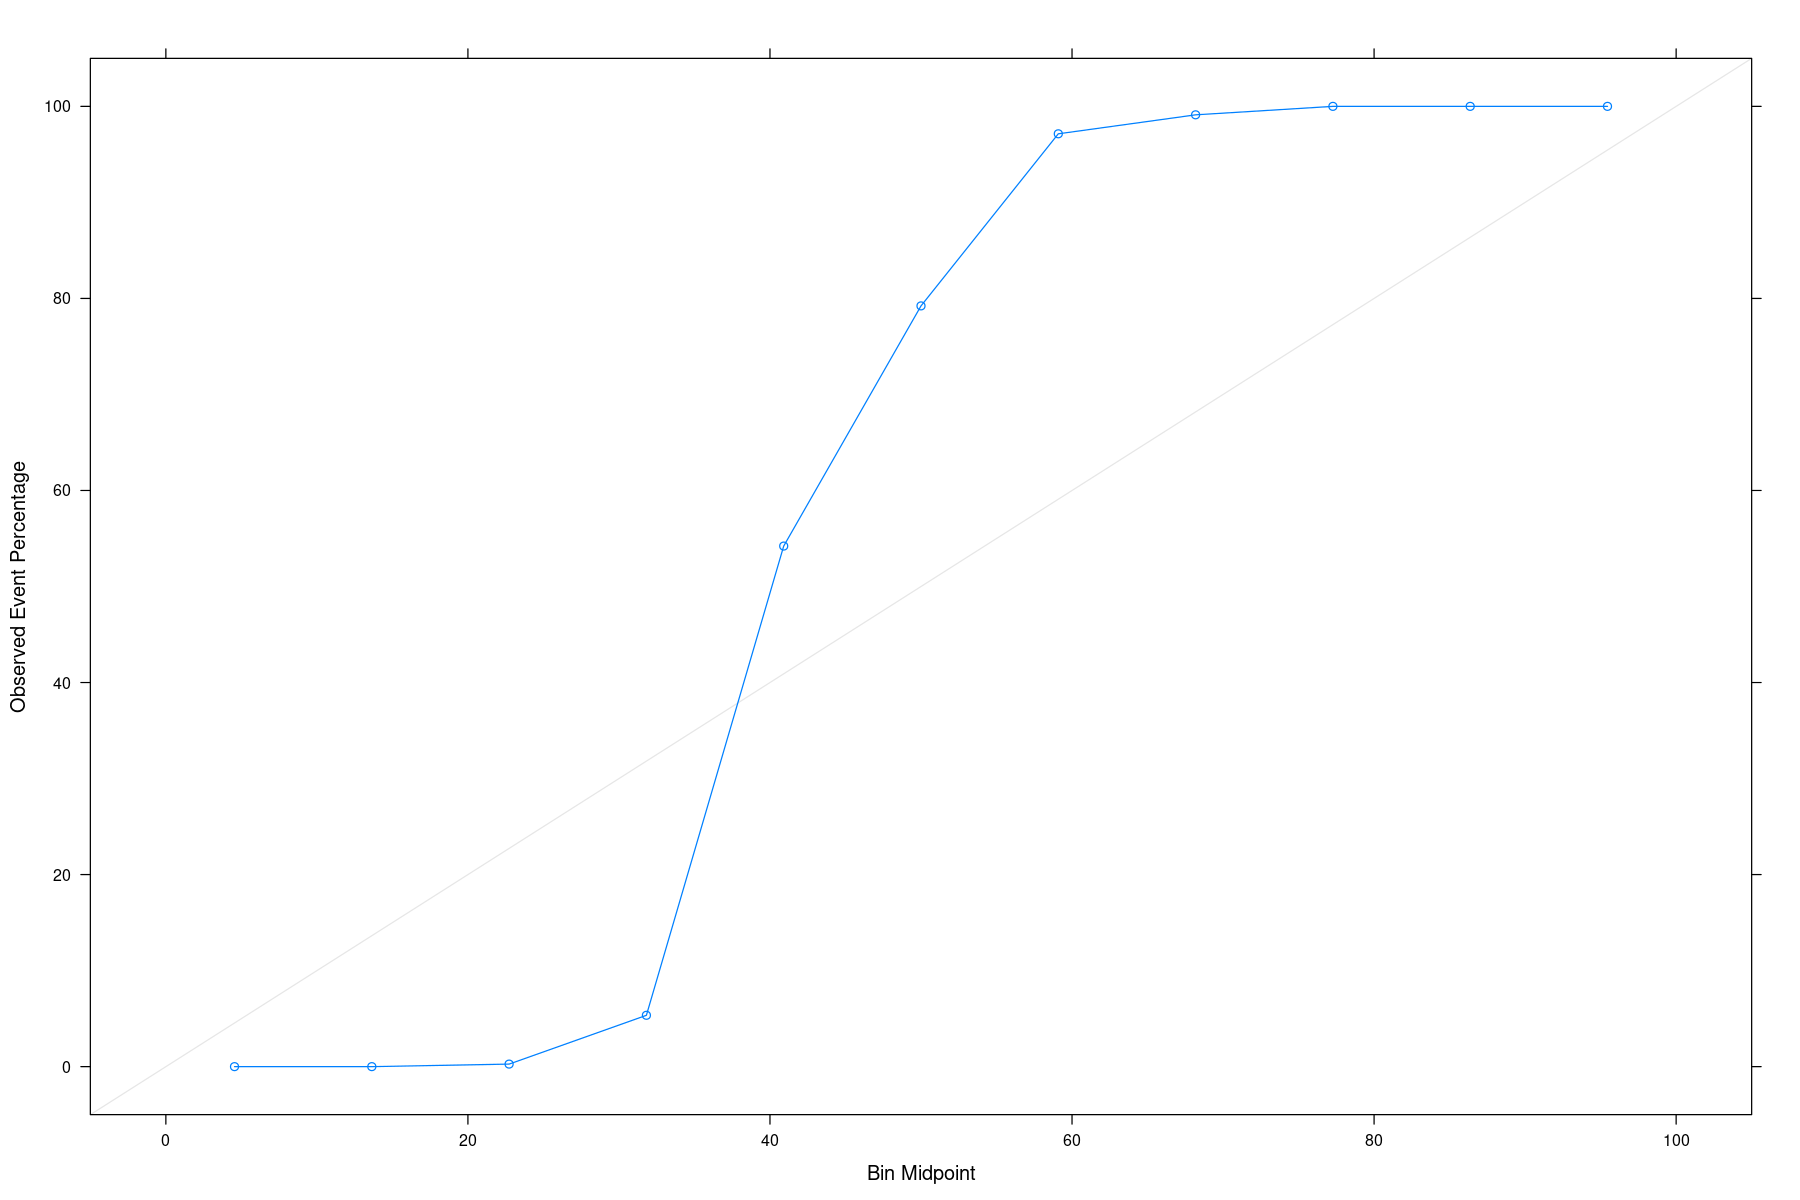

In [11]:
# Calibrating probabilities
cal_curve_ranger <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_rF, class='Yes')
#cal_curve_ranger$data
xyplot(cal_curve_ranger)

In [12]:
# Calibrate probabilities
result_rF$calibrated <- probability.calibration(y = as.numeric(factor(result_rF$obs, levels=c("No", "Yes")))-1,
                                                p = result_rF$pred_prob) 

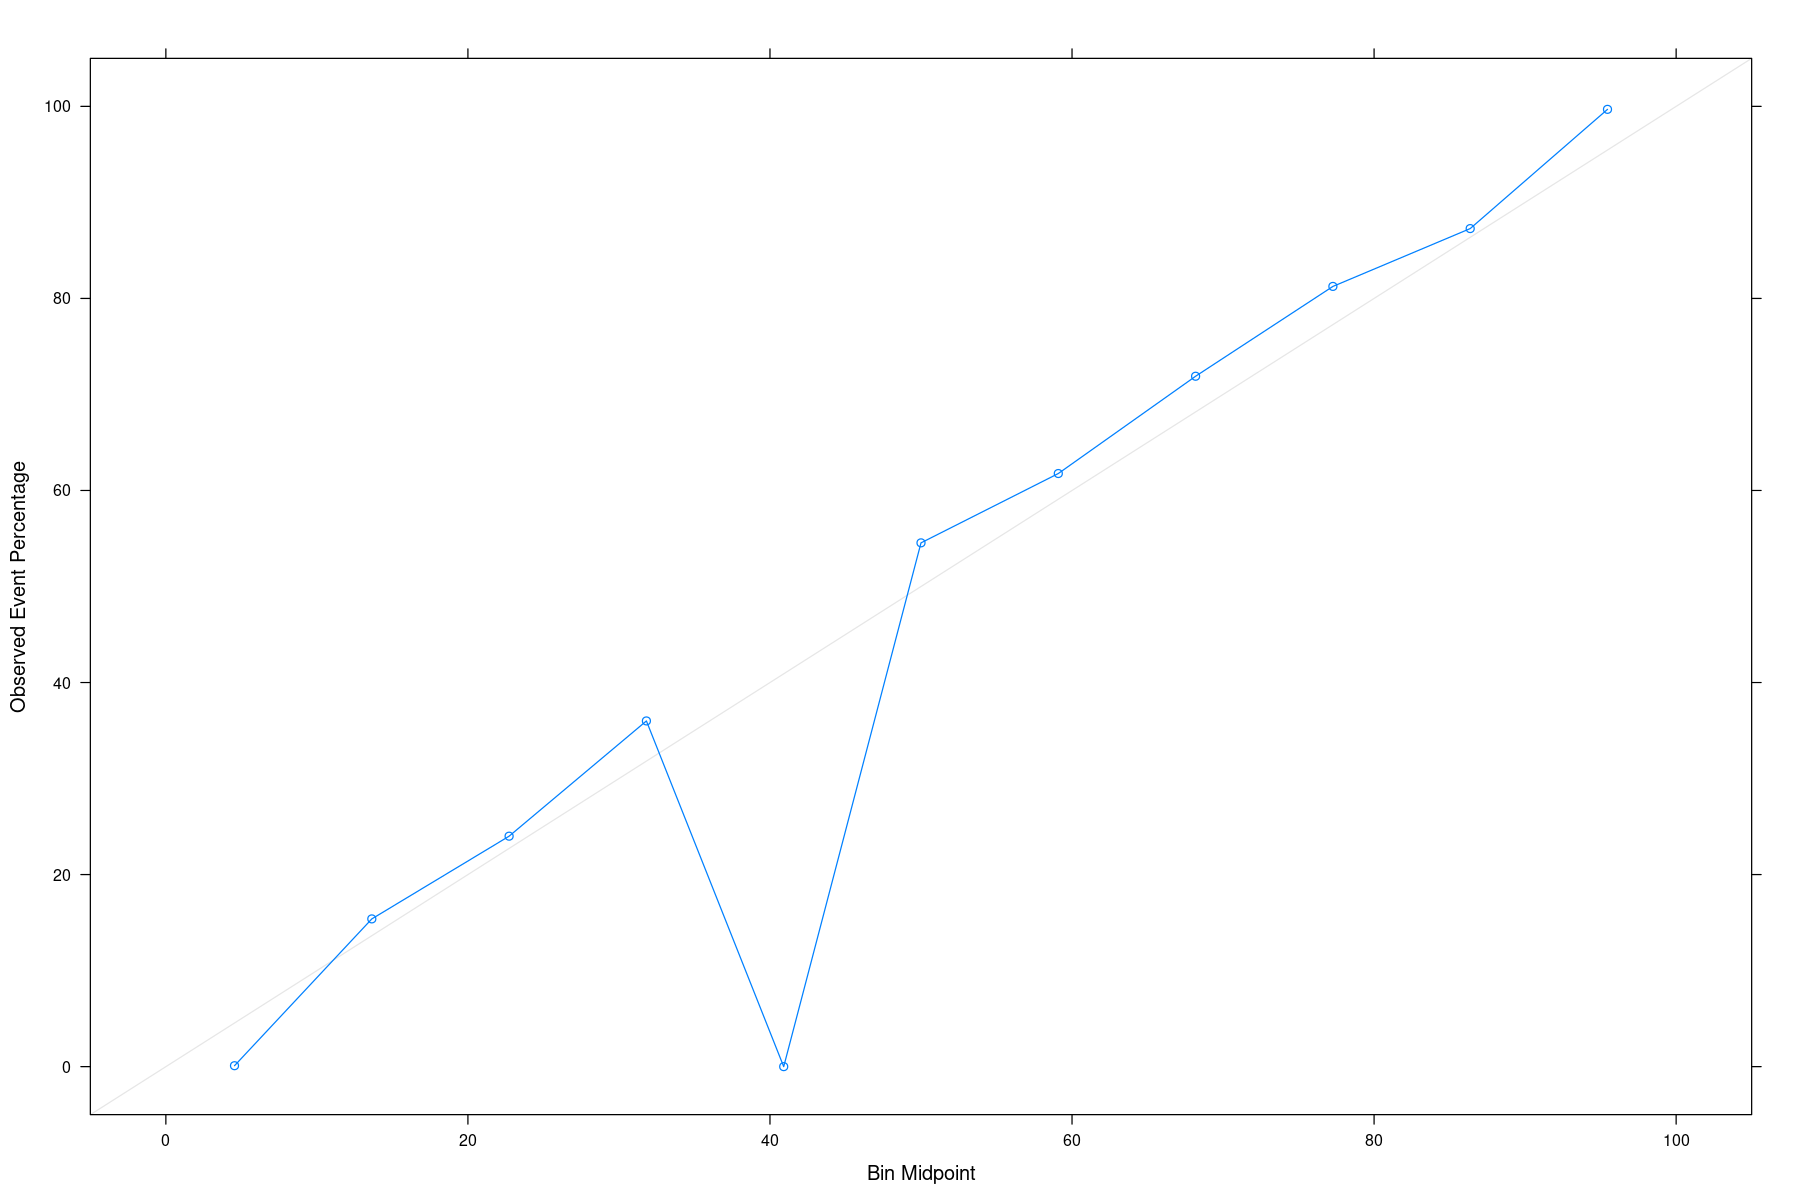

In [13]:
cal_curve_ranger2 <- caret::calibration(x = as.factor(obs) ~ calibrated, data = result_rF, class='Yes')
#cal_curve_ranger$data
xyplot(cal_curve_ranger2)

### Distribucion ajustada final

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



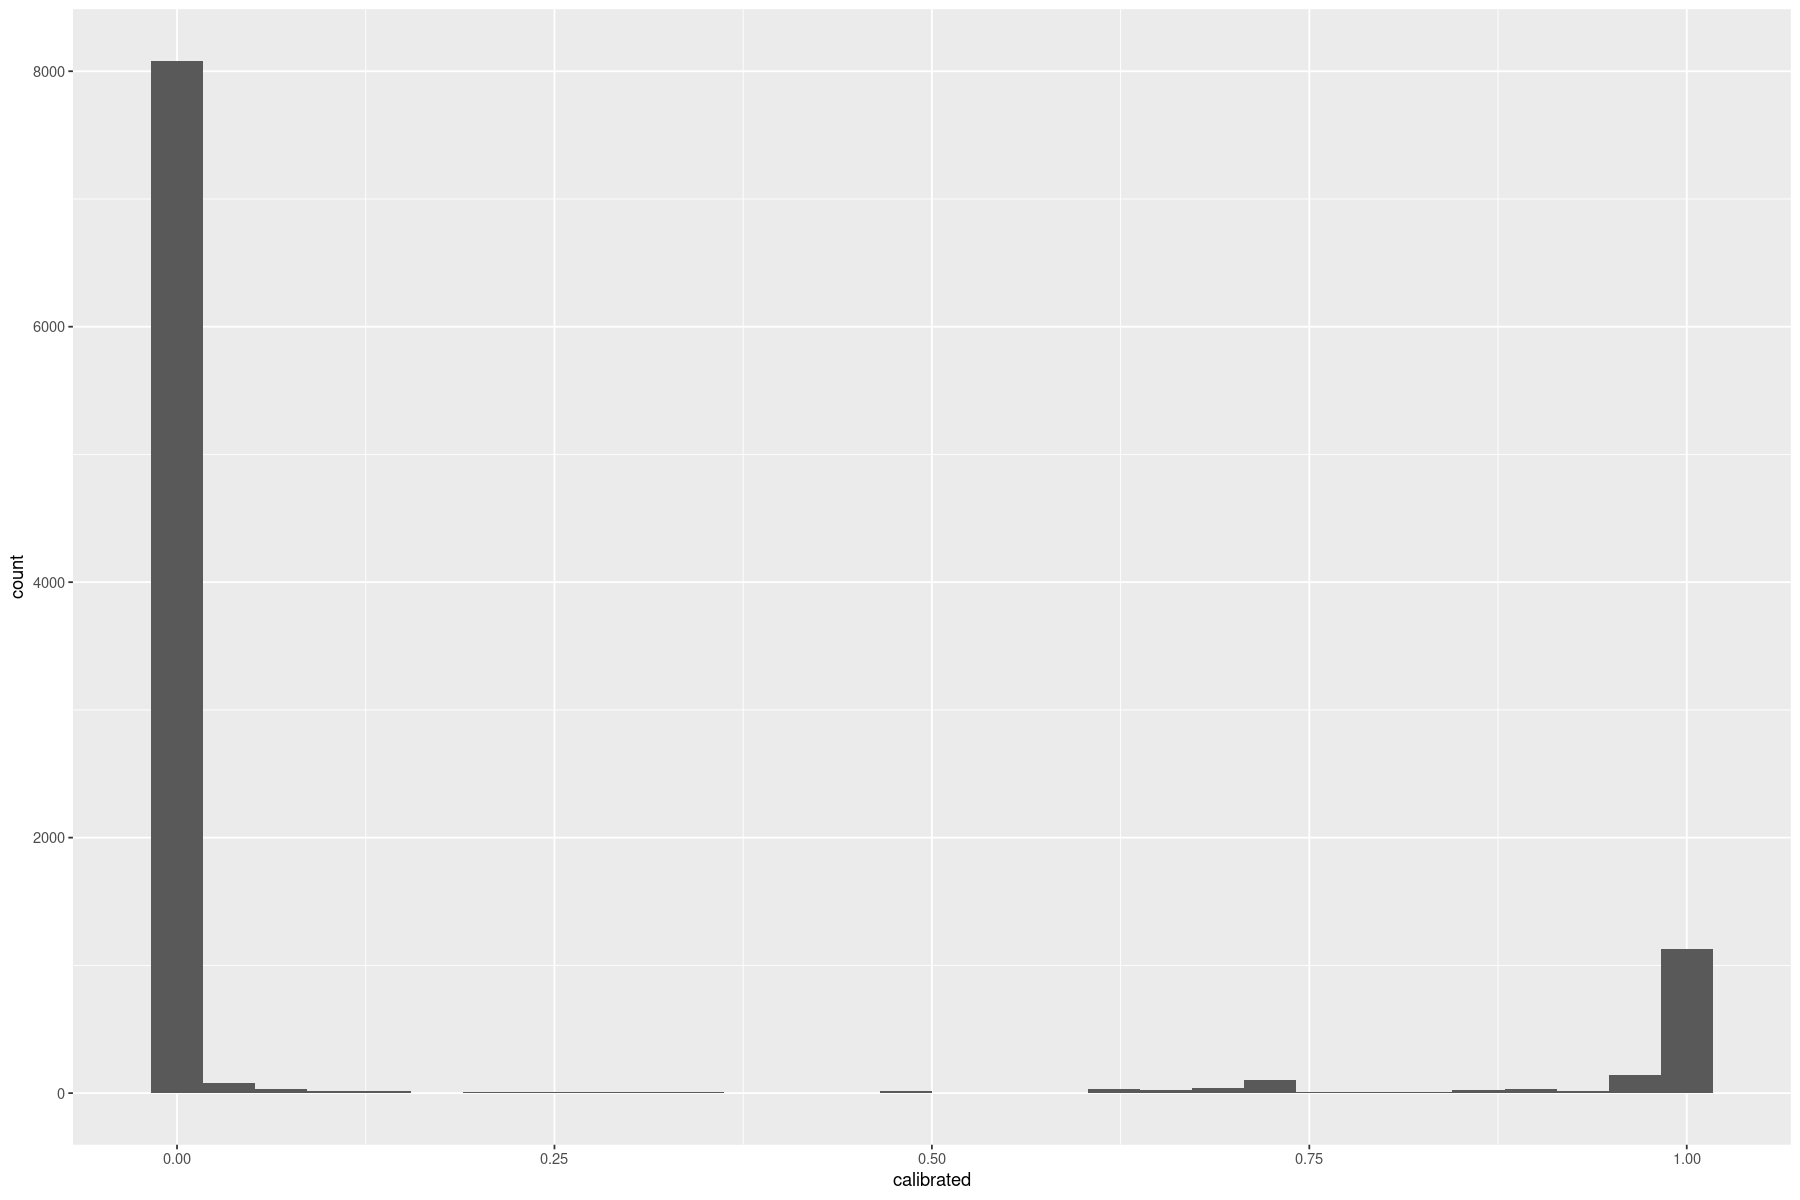

In [14]:
result_rF %>% 
    ggplot(aes(calibrated)) + 
        geom_histogram()

In [33]:
head(result_rF)

,obs,pred_prob,calibrated
,<fct>,<dbl>,<dbl>
1,No,0.0000000000,0.000000e+00
2,No,0.0000000000,0.000000e+00
3,No,0.0000000000,0.000000e+00
4,No,0.0005714286,3.361936e-05
5,No,0.0020000000,1.176678e-04
6,No,0.0000000000,0.000000e+00


## Segmentacion de las sesiones en grupos de probabilidad

In [15]:
final_df <- retention_train_clean %>% 
    bind_cols(
        result_rF %>% 
            mutate(group = ifelse(calibrated < 0.5, 'low', ifelse(calibrated < 0.9, 'medium', 'high')),
                   group = factor(group, levels=c('low', 'medium', 'high')),
                   calibrated = round(calibrated, 8))
    )
head(final_df)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,⋯,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,obs,pred_prob,calibrated,group
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,⋯,1,1,1,Returning_Visitor,FALSE,No,No,0.0000000000,0.00000000,low
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,⋯,2,1,2,Returning_Visitor,FALSE,No,No,0.0000000000,0.00000000,low
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,⋯,1,9,3,Returning_Visitor,FALSE,No,No,0.0000000000,0.00000000,low
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,⋯,2,2,4,Returning_Visitor,FALSE,No,No,0.0005714286,0.00003362,low
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,⋯,3,1,4,Returning_Visitor,TRUE,No,No,0.0020000000,0.00011767,low
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,⋯,4,3,3,Returning_Visitor,FALSE,No,No,0.0000000000,0.00000000,low


# Análisis
## Distribucion de las principales feature importances
### PageValue

In [16]:
max(final_df$PageValues)

[1] 361.7637

Warning message:
“Removed 319 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


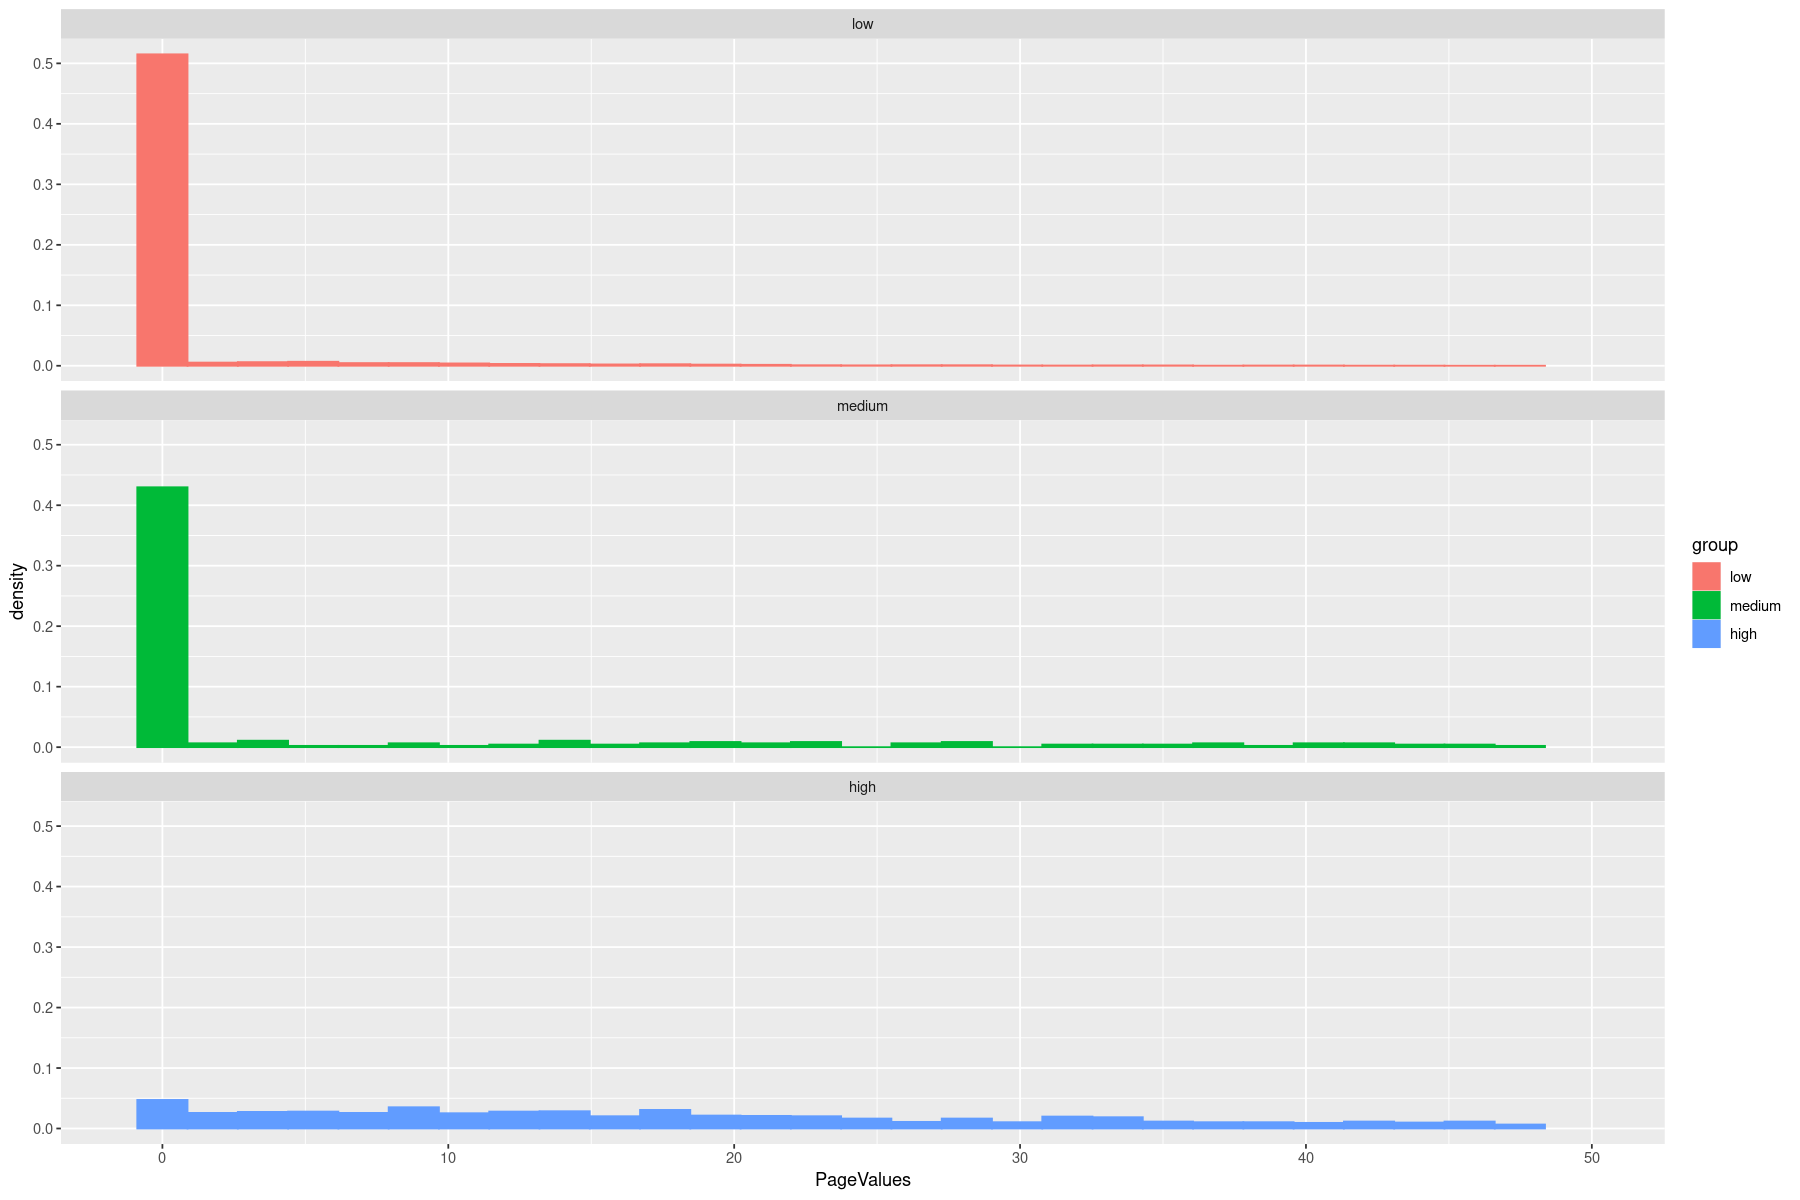

In [17]:
final_df %>% 
    ggplot(aes(x=PageValues, after_stat(density), colour=group, fill=group)) + 
        #geom_freqpoly() + 
        facet_wrap(vars(group), ncol=1) +
        geom_histogram(bins = 30) + 
        xlim(-1, 50)
        

### ProductRelated_Duration

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 63 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 9 row(s) containing missing values (geom_path).”


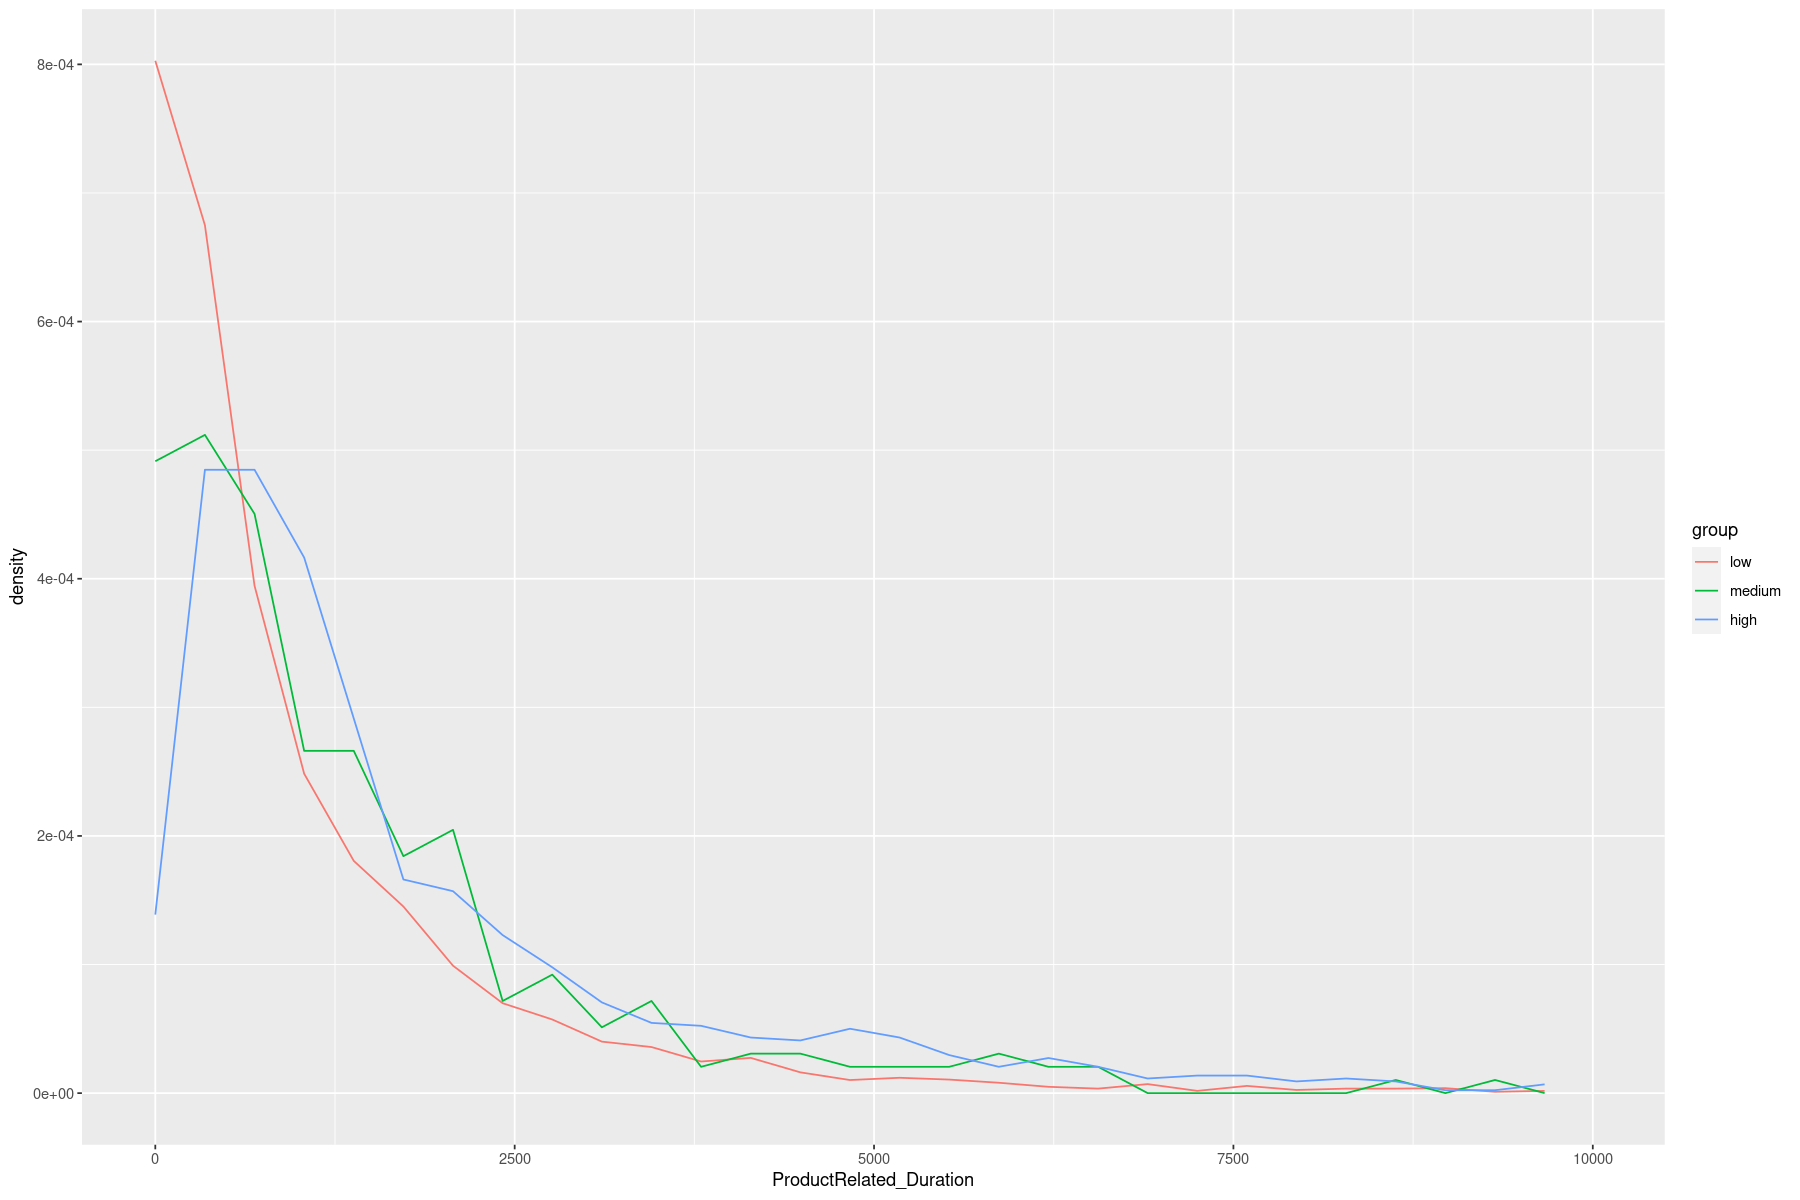

In [18]:
final_df %>% 
    ggplot(aes(x=ProductRelated_Duration, after_stat(density), colour=group, fill=group)) + 
        geom_freqpoly() + 
        xlim(-10, 10000)
        #facet_wrap(vars(group), ncol=1) +
        #geom_histogram(bins = 30)

        

### ExitRates

In [19]:
final_df %>% 
    group_by(group) %>% 
    summarise(mean_exit_rate = mean(ExitRates))

`summarise()` ungrouping output (override with `.groups` argument)



group,mean_exit_rate
<fct>,<dbl>
low,0.04762613
medium,0.02455399
high,0.01757970


In [20]:
final_df %>% 
    group_by(group) %>% 
    summarise(mean_exit_rate = mean(PageValues))

`summarise()` ungrouping output (override with `.groups` argument)



group,mean_exit_rate
<fct>,<dbl>
low,1.556659
medium,9.473456
high,31.898246


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



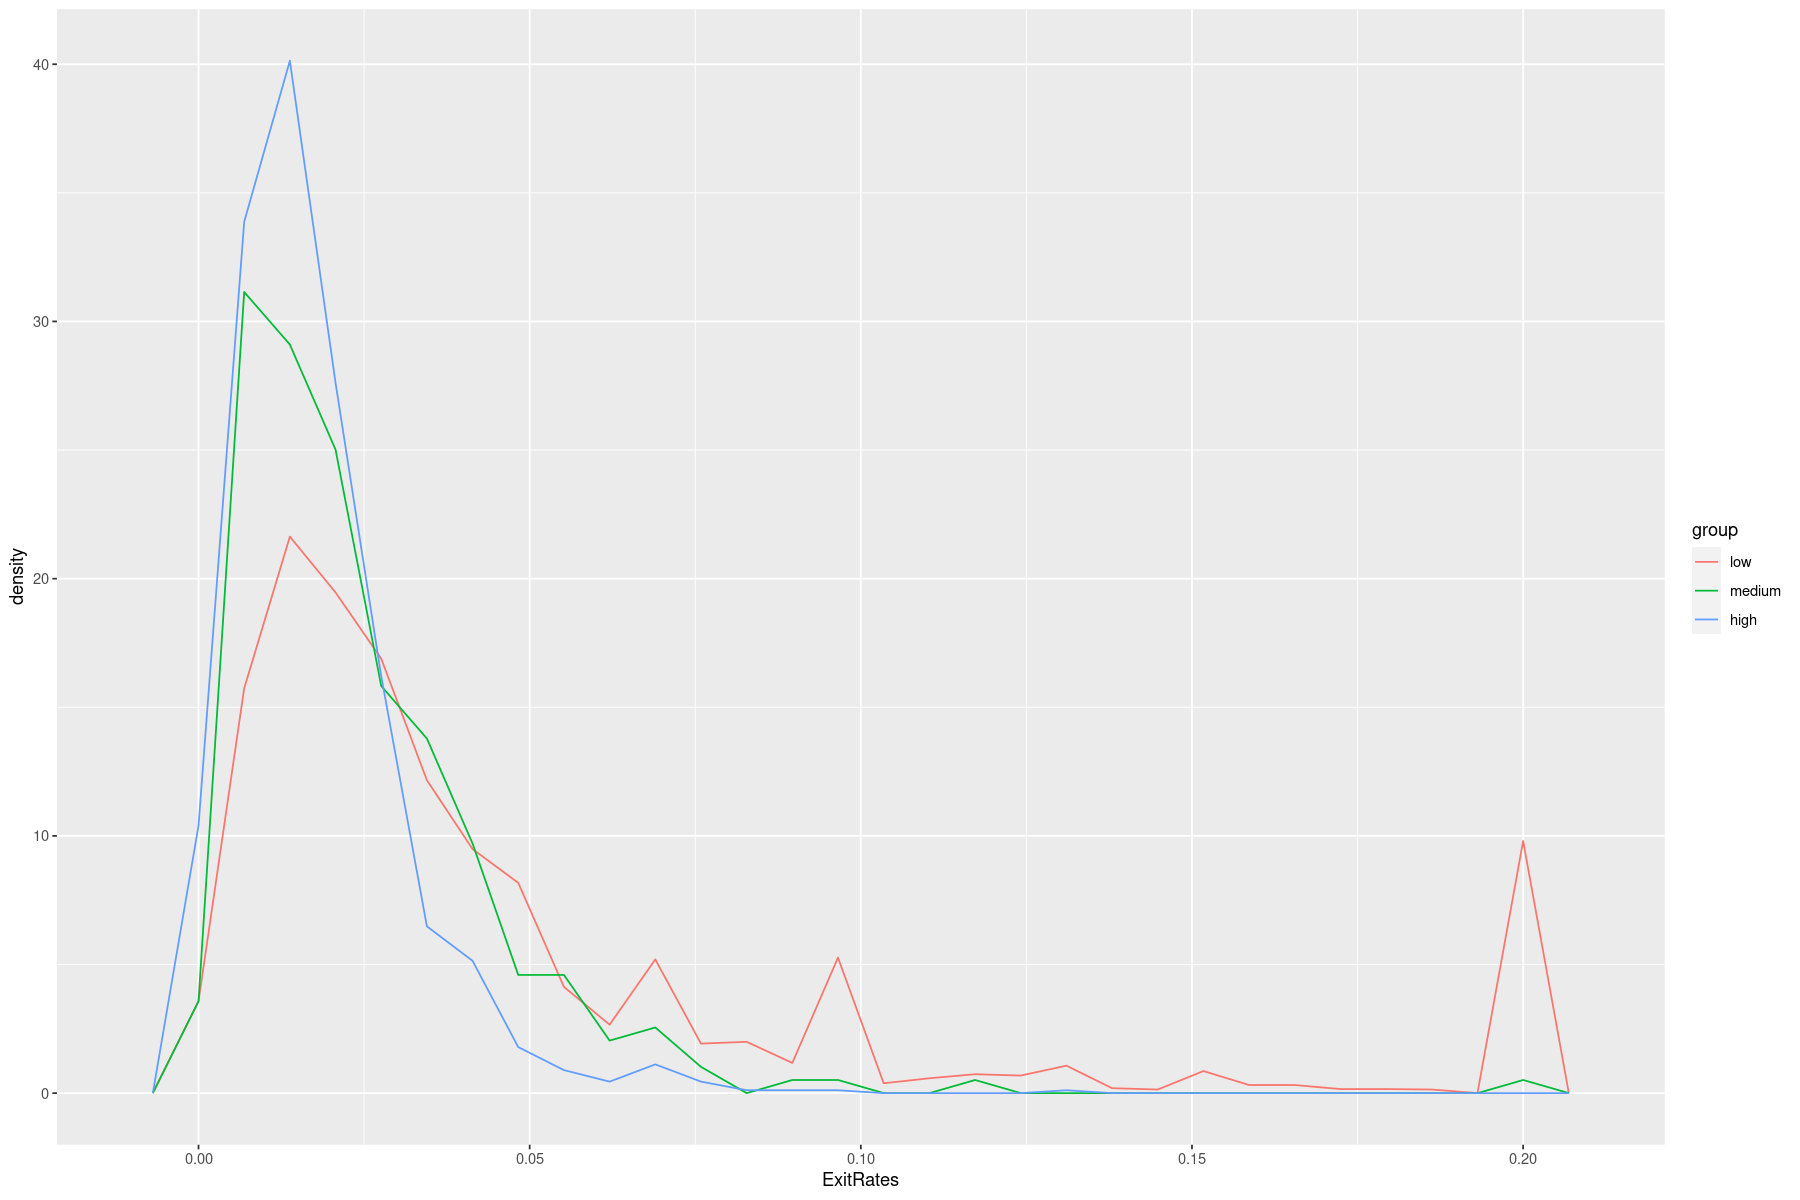

In [21]:
final_df %>% 
    ggplot(aes(x=ExitRates, after_stat(density), colour=group, fill=group)) + 
        geom_freqpoly()
        #facet_wrap(vars(group), ncol=1) +
        #geom_histogram(bins = 30)

        

### BounceRates

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



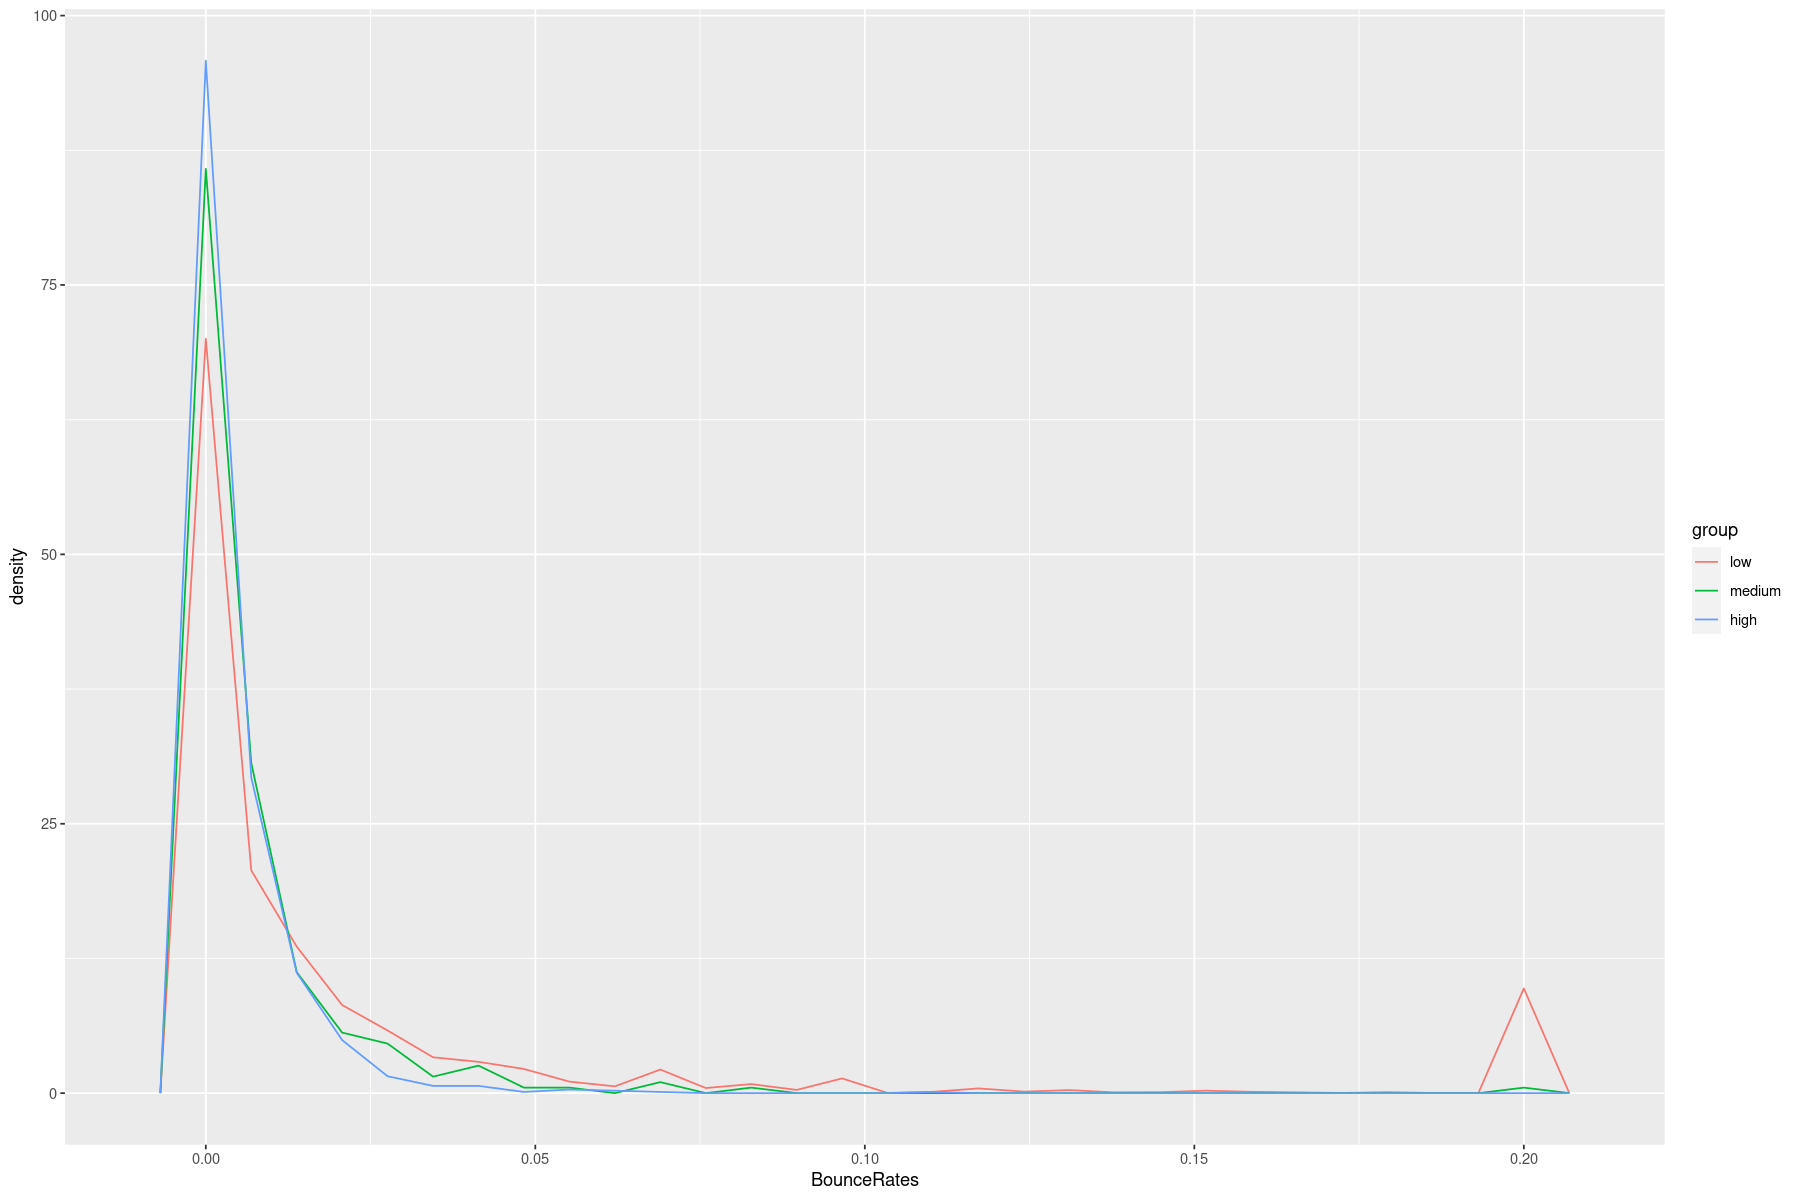

In [22]:
final_df %>% 
    ggplot(aes(x=BounceRates, after_stat(density), colour=group, fill=group)) + 
        geom_freqpoly()
        #facet_wrap(vars(group), ncol=1) +
        #geom_histogram(bins = 30)

        

### Administrative_Duration

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



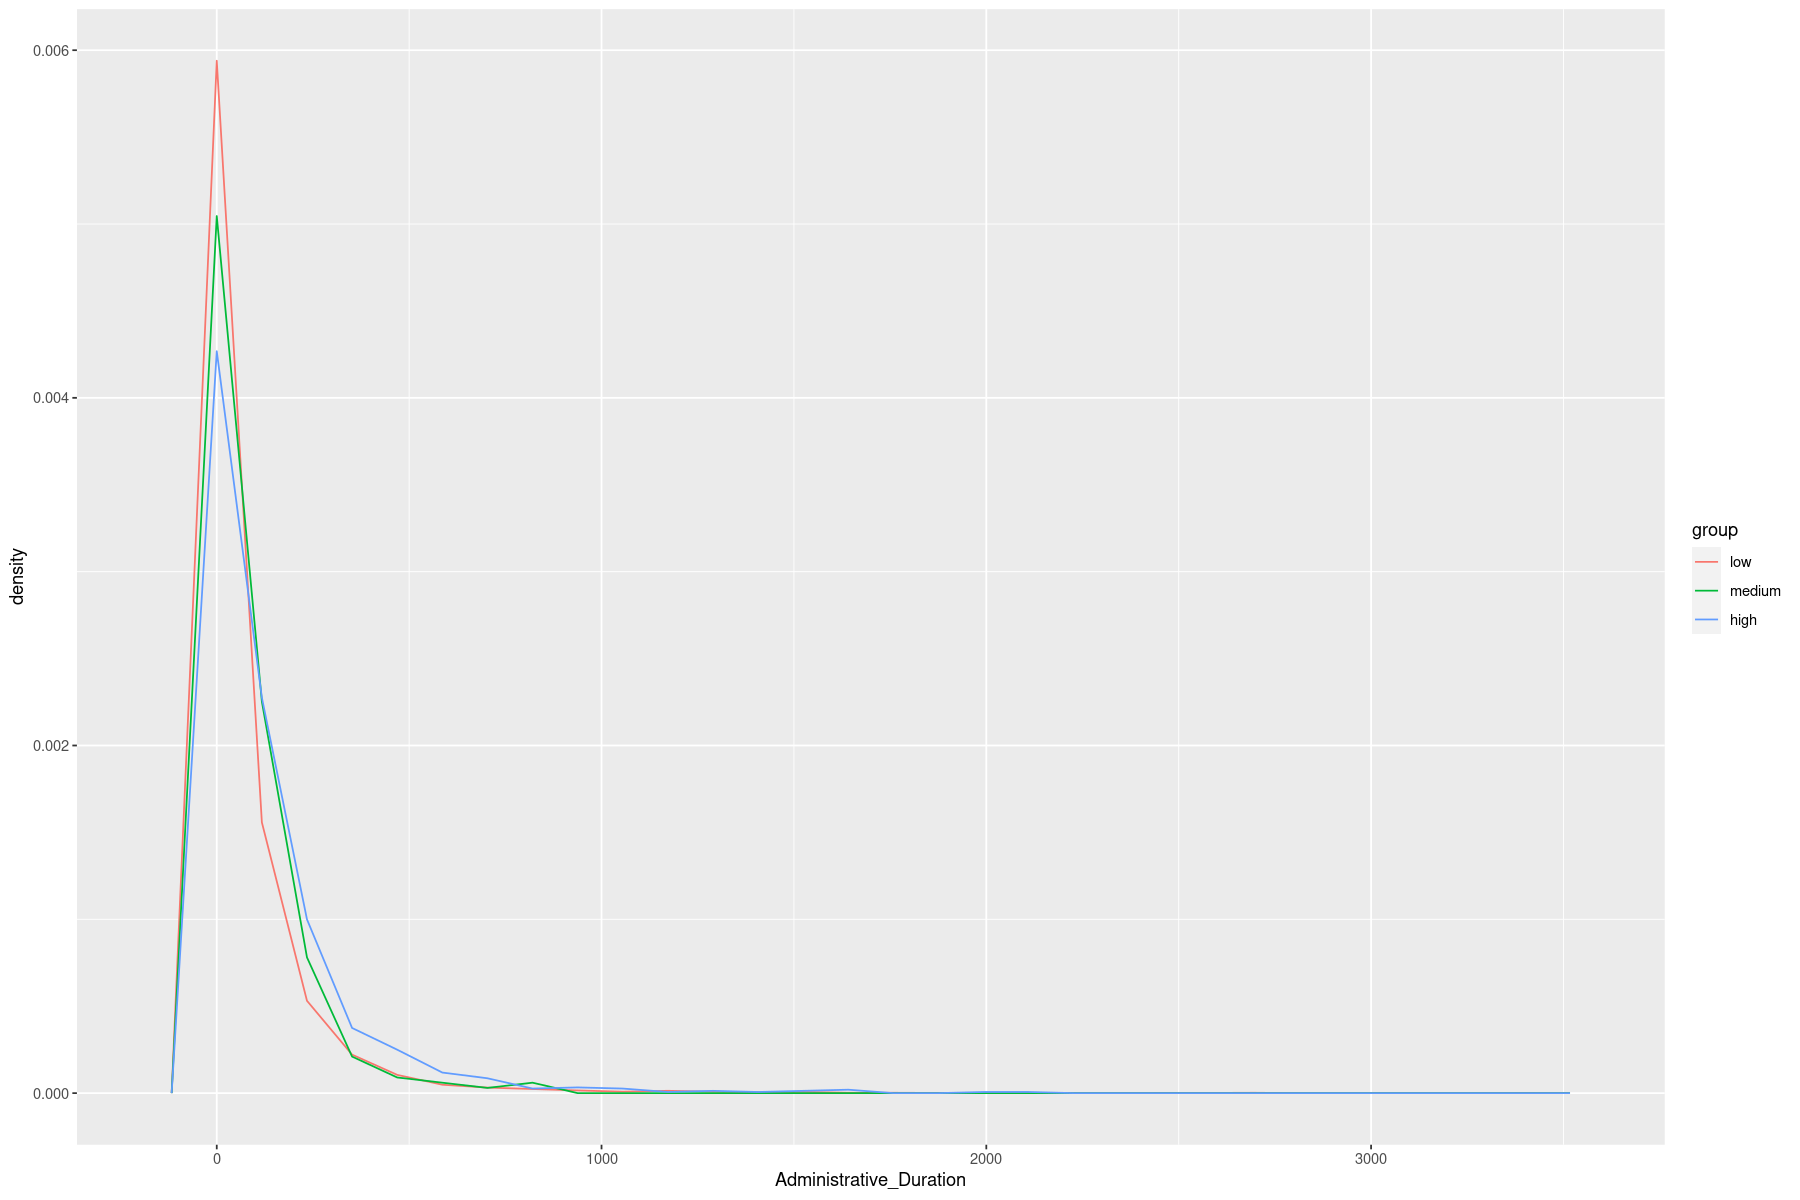

In [23]:
final_df %>% 
    ggplot(aes(x=Administrative_Duration, after_stat(density), colour=group, fill=group)) + 
        geom_freqpoly()
        #facet_wrap(vars(group), ncol=1) +
        #geom_histogram(bins = 30)

        

### Month
* ¿En que mes valdria la pena hacer alguna accion de ventas?

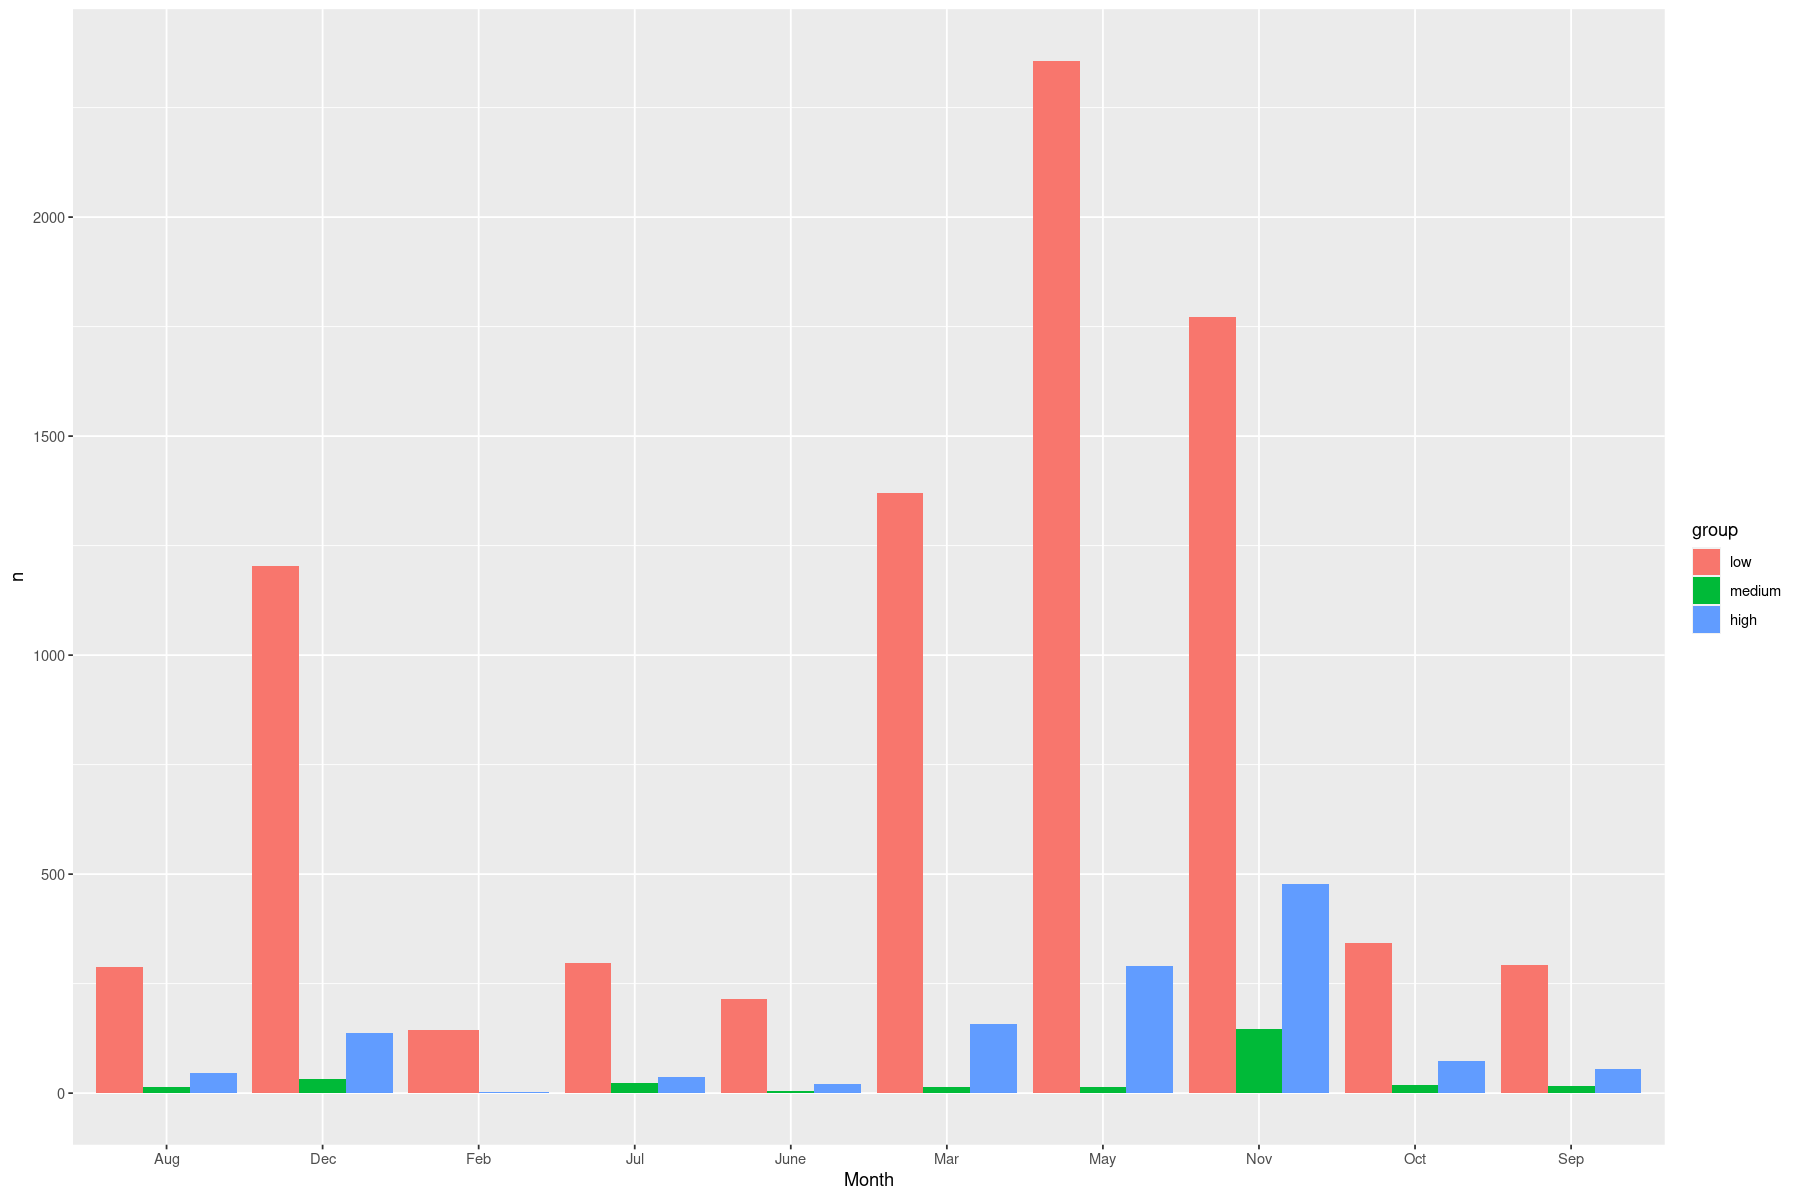

In [24]:
final_df %>% 
    group_by(Month, group) %>% 
    count() %>% 
    ungroup() %>% 
    ggplot(aes(Month, n, fill=group)) +
        geom_bar(stat = "identity", position=position_dodge())

## A nivel de producto 
* ¿Qué productos visitan las sesiones con alta probabilidad de compra?
* ¿Qué productos visitan las sesiones con baja probabilidad de compra?
* ¿En que productos podriamos actuar donde las sesiones tiene una probabilidad intermedia?



### Probabilidad promedio por producto

`summarise()` ungrouping output (override with `.groups` argument)



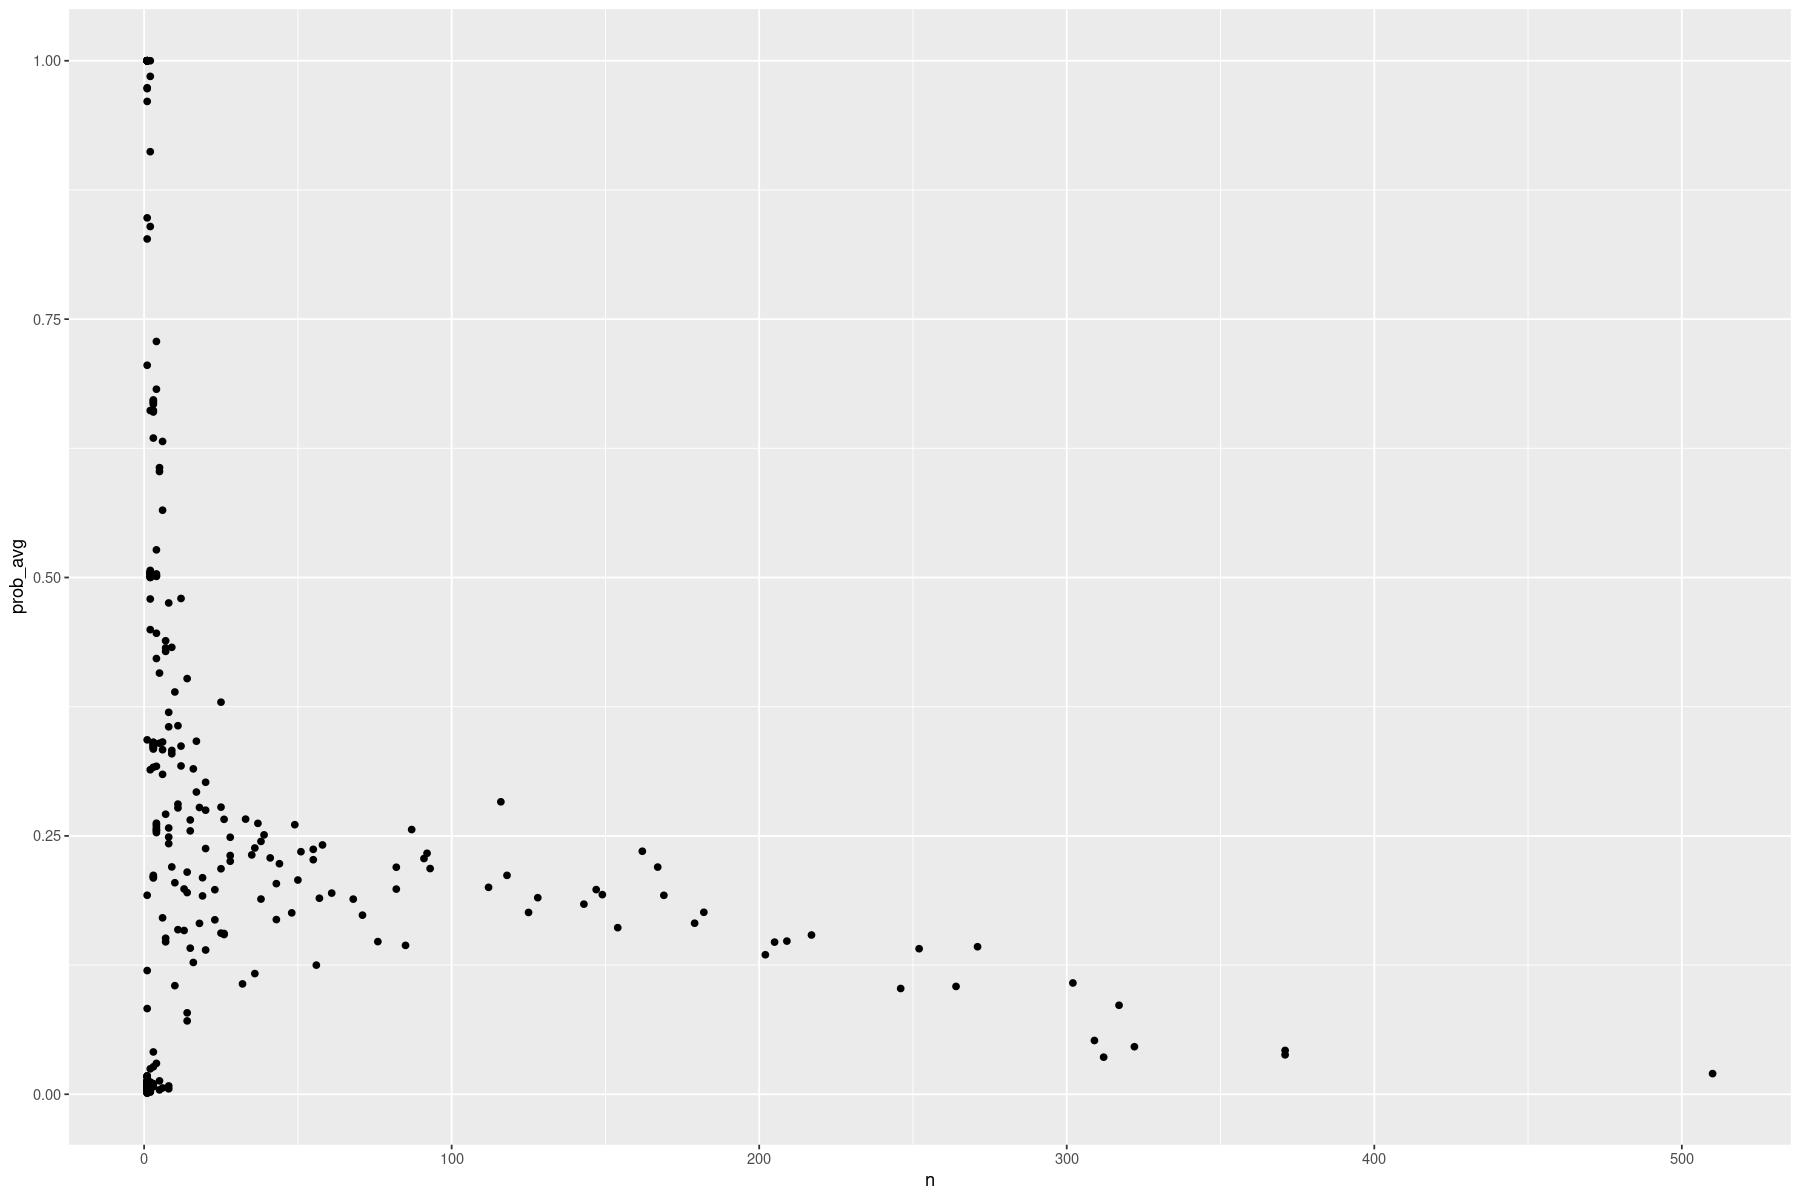

In [25]:
product_prob_avg <- final_df %>% 
    group_by(ProductRelated) %>% 
    summarise(n=n(), prob_avg = mean(calibrated)) %>% 
    ungroup() %>% 
    #filter(n>100) %>% 
    arrange(desc(n))

product_prob_avg %>% ggplot(aes(n, prob_avg)) + geom_point()

Donde deberiamos poner el foco?
* trade-off entre numero numero de sesiones que llegan a un producto v/s la probabilidad promedio
* Si existiera la variable custumer_id podriamos tratar de cuantificar a los custumer por ejemplo con cuanto han gastado en el sitio web y como es su probabilidad de con el fin de analisar que usuario podrian tener mayor importancia al momento de aplicar una campaña


In [26]:
product_prob_avg %>% head(20)

ProductRelated,n,prob_avg
<fct>,<int>,<dbl>
1,510,0.01997487
2,371,0.03816576
3,371,0.04241621
6,322,0.04601420
7,317,0.08612457
4,312,0.03588787
5,309,0.05202076
8,302,0.10769823
10,271,0.14275037


### Top 10 de productos con probabilidad alta de compra

In [27]:
final_df %>% 
    filter(group == 'high') %>% 
    group_by(ProductRelated) %>% 
    count() %>% 
    arrange(desc(n)) %>% 
    head(10)
    

ProductRelated,n
<fct>,<int>
10,34
12,32
21,32
22,31
13,29
19,29
30,29
8,27
14,26


### Top 10 de productos con probabilidad intermedia de compra

In [28]:
final_df %>% 
    filter(group == 'medium') %>% 
    group_by(ProductRelated) %>% 
    count() %>% 
    arrange(desc(n)) %>% 
    head(10)
    

ProductRelated,n
<fct>,<int>
7,10
16,9
20,9
2,8
21,8
22,8
3,8
17,7
24,7


### Top 10 de productos con probabilidad baja de compra

In [29]:
final_df %>% 
    filter(group == 'low') %>% 
    group_by(ProductRelated) %>% 
    count() %>% 
    arrange(desc(n)) %>% 
    head(10)
    

ProductRelated,n
<fct>,<int>
1,500
2,355
3,354
6,307
4,299
5,291
7,287
8,268
9,236


Dado un presupuesto acotado podriamos suguerir poner foco en los producto con probabilidad intermedia dado que son estos los que tienen mas chance de llegara convertir.

## Foco 

`summarise()` regrouping output by 'group' (override with `.groups` argument)



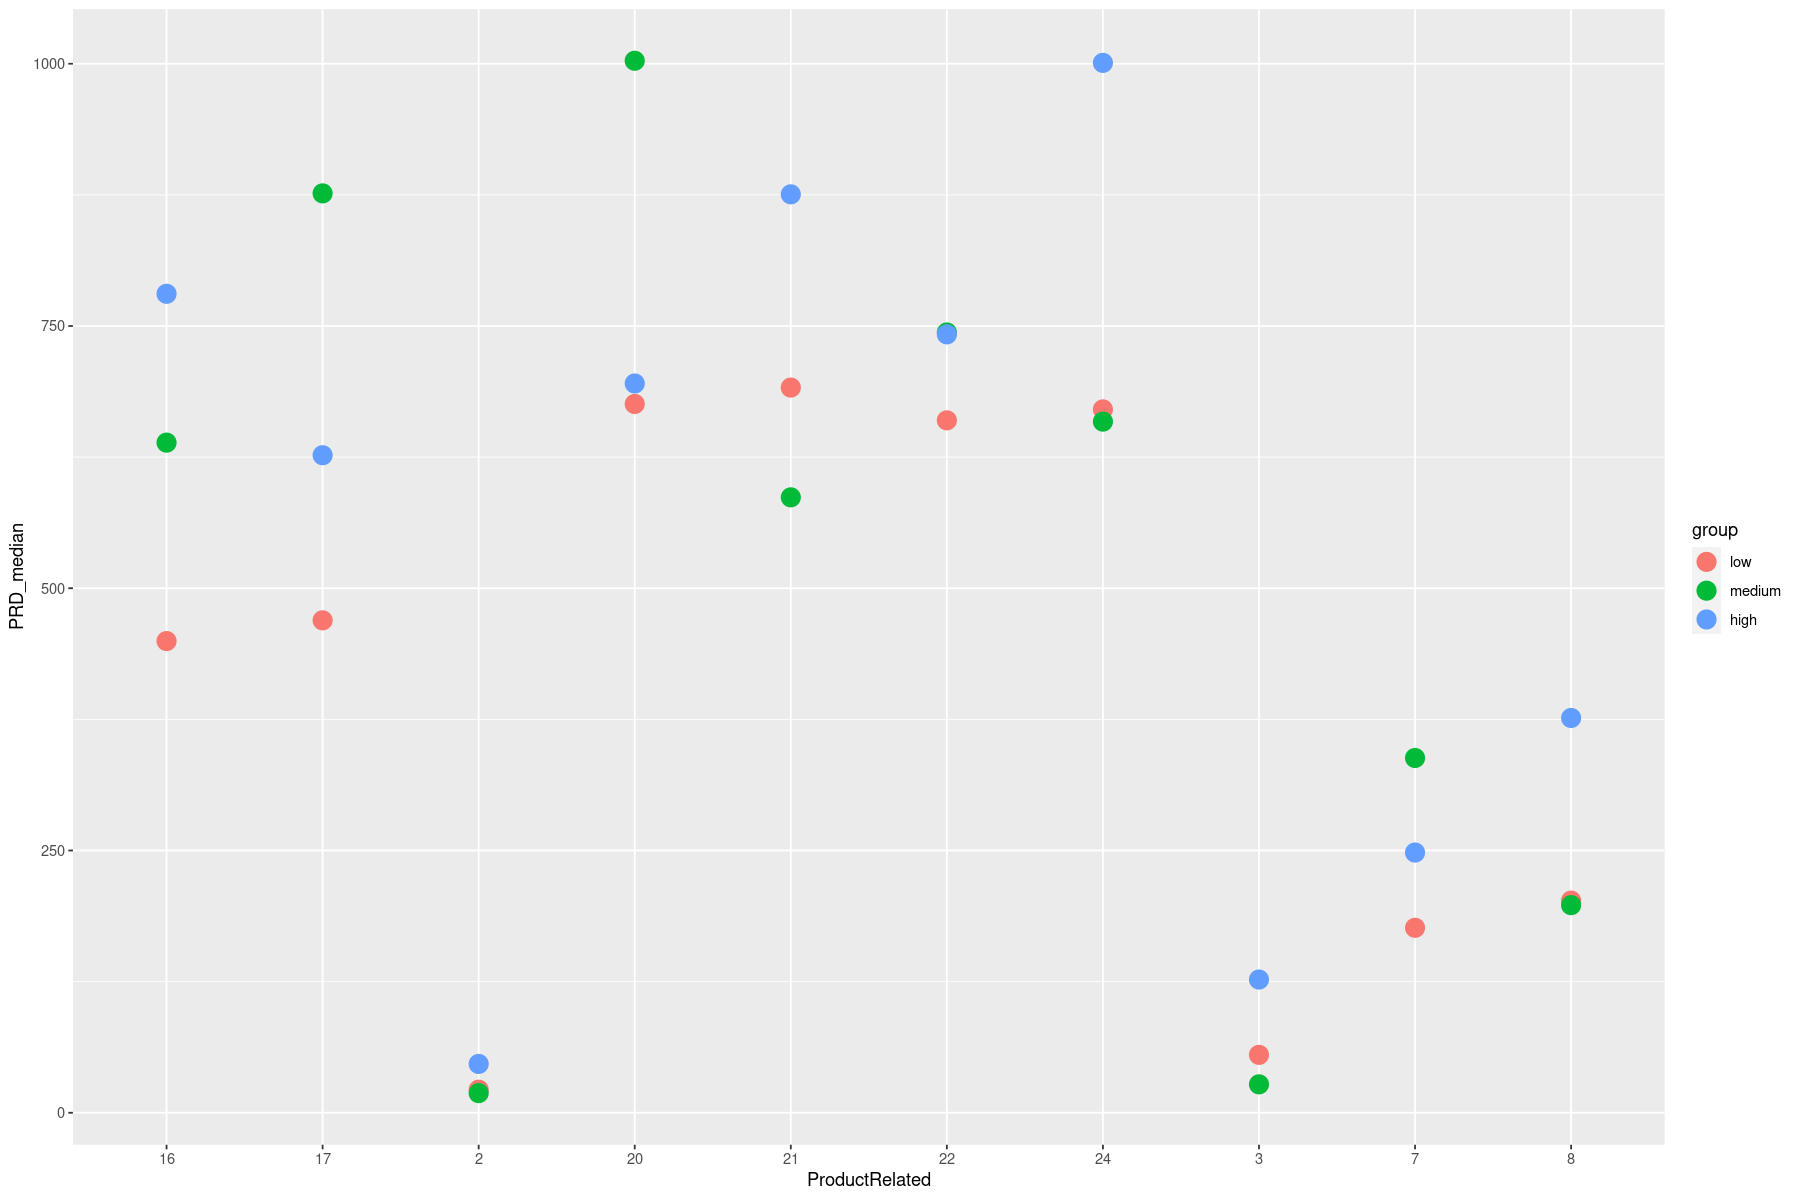

In [30]:
top_medium <- final_df %>% 
    filter(group == 'medium') %>% 
    group_by(ProductRelated) %>% 
    count() %>% 
    arrange(desc(n)) %>% 
    head(10)

final_df %>% 
    filter(ProductRelated %in% top_medium$ProductRelated) %>% 
    group_by(group, ProductRelated) %>% 
    summarise(PRD_median = median(ProductRelated_Duration)) %>% 
    ungroup() %>% 
    ggplot(aes(ProductRelated, PRD_median, color=group)) + geom_point(size=5)

## PDP

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”


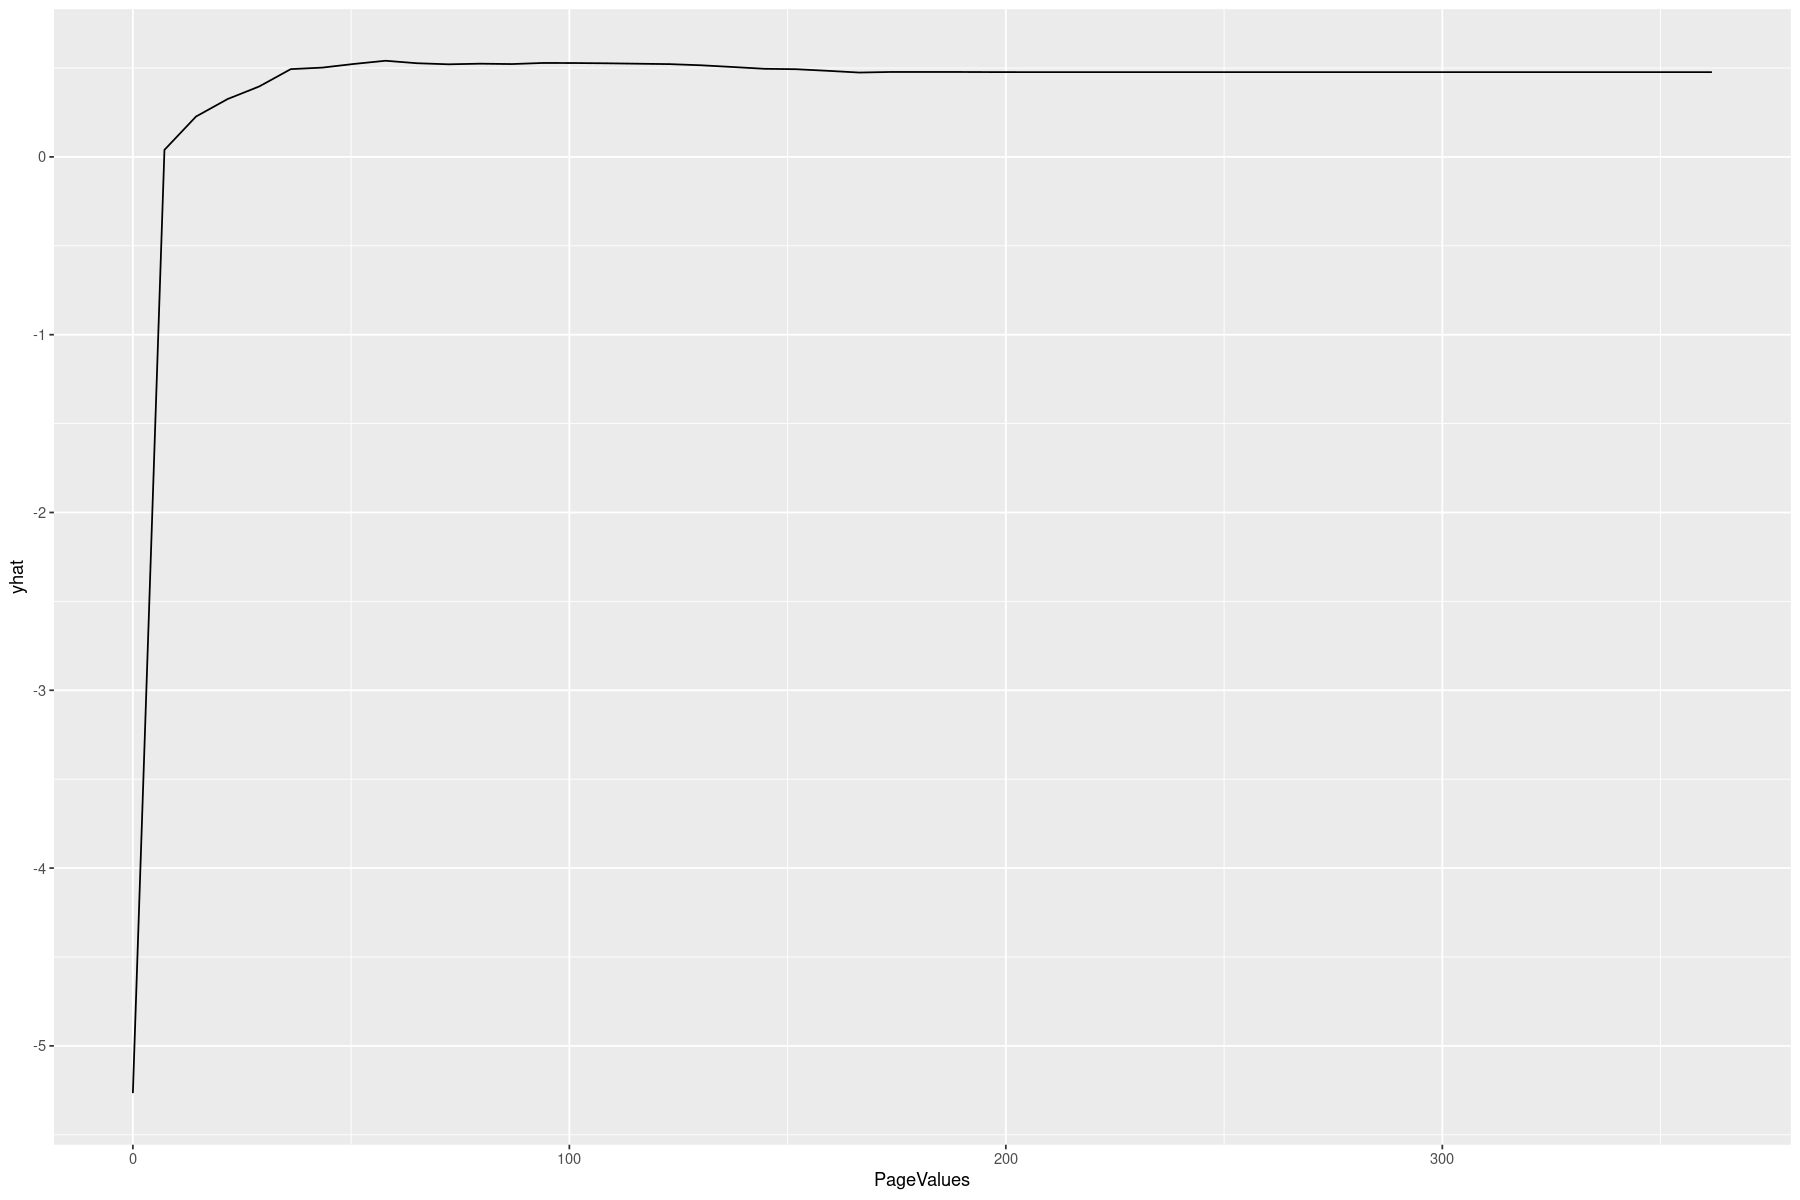

In [31]:
pd <- pdp::partial(retention_model,
              pred.var = c("PageValues"),
              chull = TRUE,
              which.class=1,
              type="classification",
             )
autoplot(pd, contour = TRUE)

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”


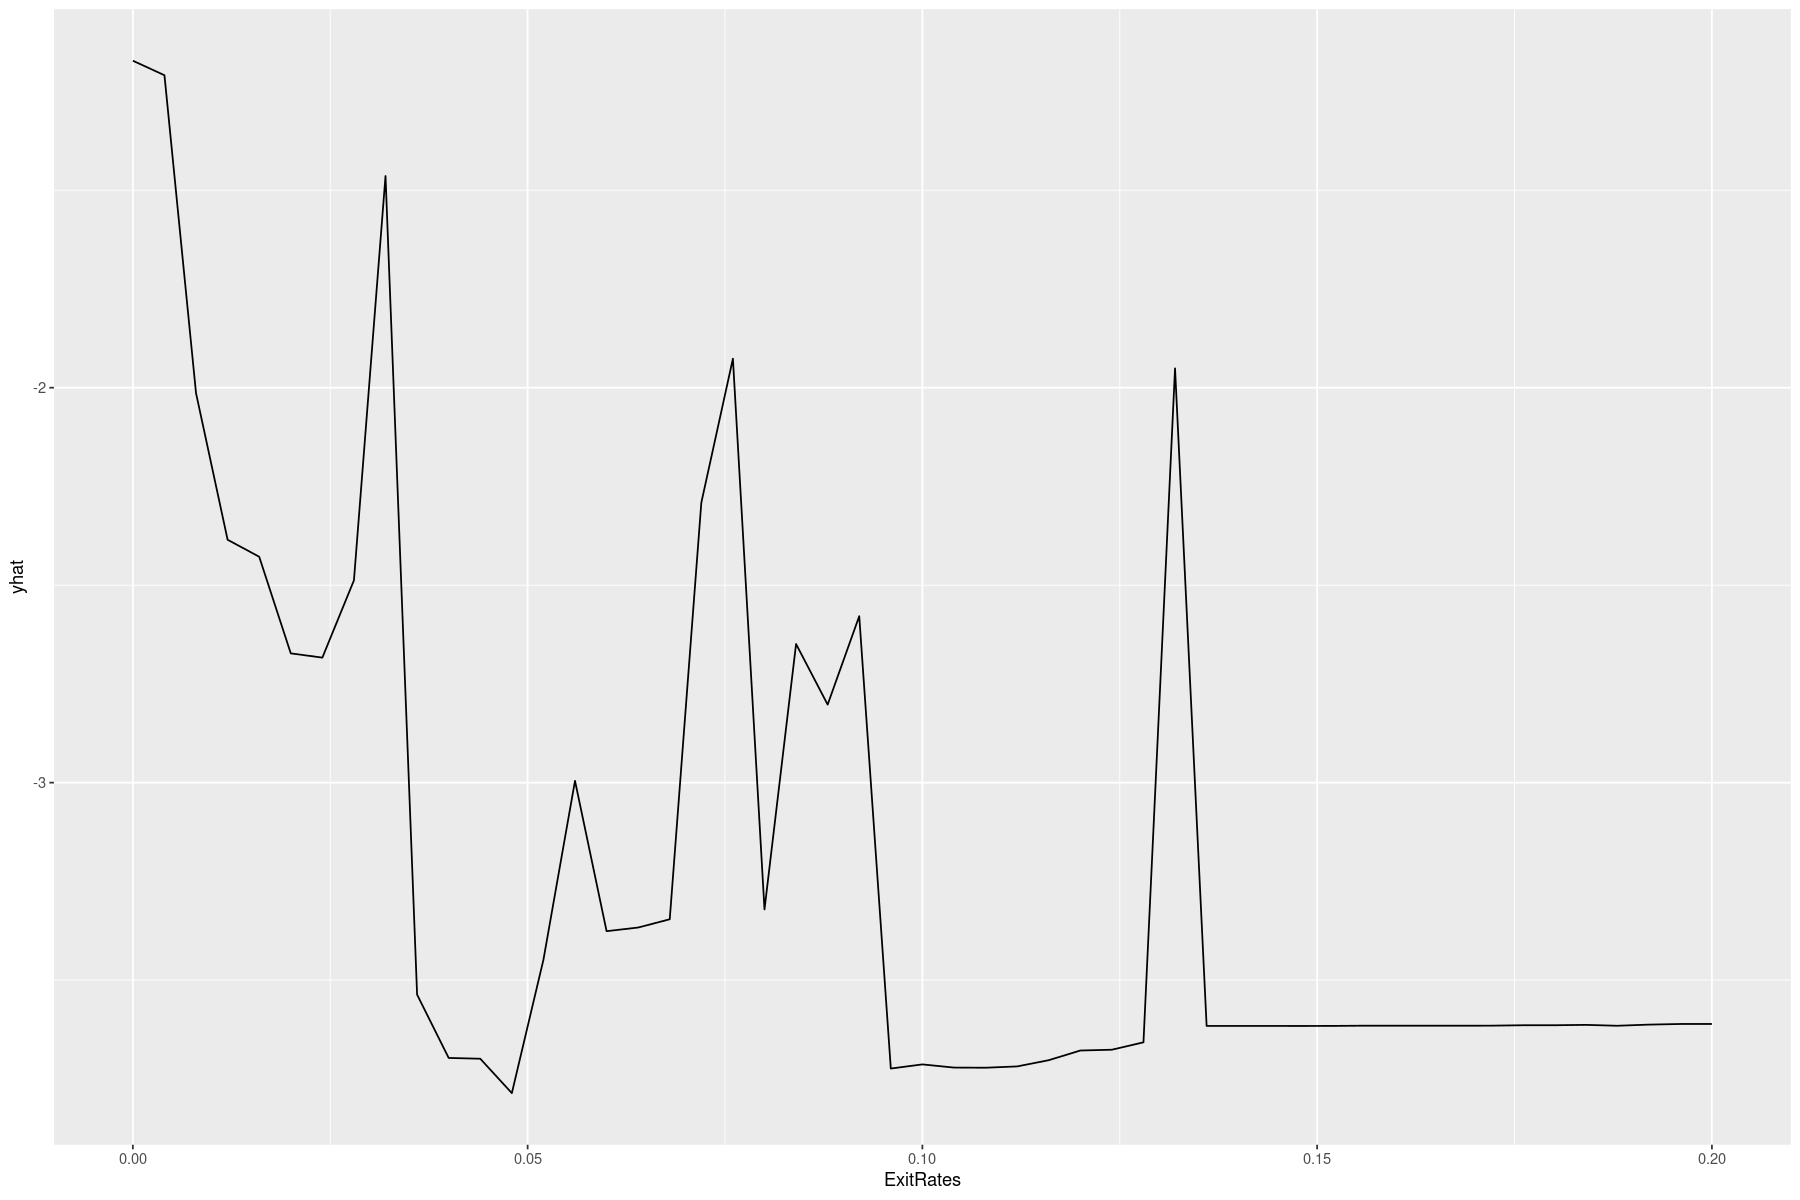

In [32]:
pd <- pdp::partial(retention_model,
              pred.var = c("ExitRates"),
              chull = TRUE,
              which.class=1,
              type="classification",
             )
autoplot(pd, contour = TRUE)